In [2]:
import pandas as pd
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
import os
import shutil

## Number of data samples and classes (multi-class, multi-label)

In [ ]:
import zipfile
with zipfile.ZipFile('./data/data.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

In [3]:
# Path to csv containing data labels
path_to_csv = './data/Data_Entry_2017.csv'
df = pd.read_csv(path_to_csv)

# Print the labels data
df['Finding Labels']

0                   Cardiomegaly
1         Cardiomegaly|Emphysema
2          Cardiomegaly|Effusion
3                     No Finding
4                         Hernia
                   ...          
112115            Mass|Pneumonia
112116                No Finding
112117                No Finding
112118                No Finding
112119                No Finding
Name: Finding Labels, Length: 112120, dtype: object

In [4]:
# Process data as some of the images have multiple labels
# Separate the labels to the unique classes
classes_split = pd.DataFrame({'Finding Labels': chain.from_iterable(df['Finding Labels'].str.split('|'))})
labels = classes_split['Finding Labels'].unique()
labels

array(['Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation'], dtype=object)

## Visualize the data and class distribution

In [5]:
# Encoding dataframe
encoded_df = pd.DataFrame(columns=labels)
encoded_df.insert(0, 'Image Index', df['Image Index'])
for col in encoded_df.columns:
    if col != 'Image Index':
        encoded_df[col] = 0

for i, row in df.iterrows():
    values = row['Finding Labels'].split('|')
    for val in values:
        encoded_df.iloc[i, encoded_df.columns.get_loc(val)] = 1 

In [ ]:
# Dataframe, encoded for multi-label classification
encoded_df.to_csv('./data/Labels/Encoded_Multilabels.csv', index=False)

Cardiomegaly 2776
Emphysema 2516
Effusion 13317
No Finding 60361
Hernia 227
Infiltration 19894
Mass 5782
Nodule 6331
Atelectasis 11559
Pneumothorax 5302
Pleural_Thickening 3385
Pneumonia 1431
Fibrosis 1686
Edema 2303
Consolidation 4667


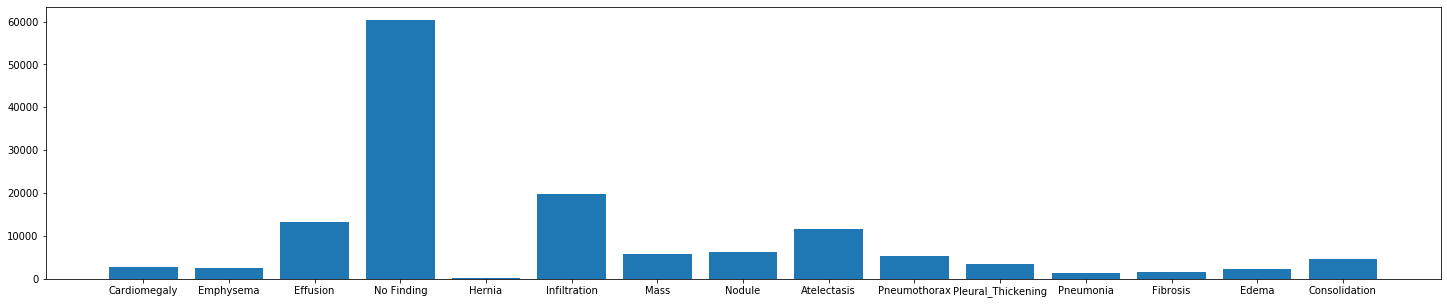

In [6]:
samples = {}
for col in encoded_df.columns:
    if col != 'Image Index':
        tot = encoded_df[col].sum()
        samples[col] = tot
        print(col, end=" ") 
        print(tot)

# Current split of data between the different classes
plt.figure(figsize=(25,5))
plt.bar(range(len(samples)), list(samples.values()), align='center')
plt.xticks(range(len(samples)), list(samples.keys()))
plt.show()

In [7]:
encoded_df

,Image Index,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00000001_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
112116,00030802_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
112117,00030803_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
112118,00030804_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Organize the data into Train, Test, and Validation Folders

In [8]:
# Organize the data into training and testing folders given the list of files
train_list = './data/train_val_list.txt'
test_list = './data/test_list.txt'

train = [line.rstrip() for line in open(train_list)]
test = [line.rstrip() for line in open(test_list)]

In [ ]:
path_to_images = './data/images'
paths = os.listdir(path_to_images)
for folder in paths:
    folder_path = os.path.join(path_to_images, folder + '/images')
    images = os.listdir(folder_path)
    for img in images:
        if img in train:
            shutil.move(os.path.join(folder_path, img), './data/Train')
        else:
            shutil.move(os.path.join(folder_path, img), './data/Test')

In [ ]:
# Further split the training data into validation and training sets, using a 80/20 split 
# Drop all 'No Finding' data
encoded_df = encoded_df[encoded_df['No Finding'] == 0]
encoded_df = encoded_df.drop(columns='No Finding')

test_label_df = encoded_df[encoded_df['Image Index'].isin(test)]
train_val_label_df = encoded_df[encoded_df['Image Index'].isin(train)]

msk = np.random.rand(len(train_val_label_df)) < 0.90
train_label_df = train_val_label_df[msk]
val_label_df = train_val_label_df[~msk]

In [ ]:
# Move files
val = list(val_label_df['Image Index'])
path = os.listdir('./data/Train')
for img in path:
    if img in val:
        shutil.move(os.path.join('./data/Train', img), './data/Val')

In [ ]:
msk = np.random.rand(len(test_label_df)) > 0.80
new_test = test_label_df[msk]
new_train = pd.concat([train_label_df, test_label_df[~msk]])

In [ ]:
# Save the Encoded train, test, and validation dataframes
new_test.to_csv('./data/Labels/Test_Labels.csv', index=False)
new_train.to_csv('./data/Labels/Train_Labels.csv', index=False)
val_label_df.to_csv('./data/Labels/Val_Labels.csv', index=False)

In [ ]:
# Compute Data Statistics
from PIL import Image, ImageStat
mean = 0.
std = 0.
nb_samples = 0
path = os.listdir('./data/Train')
for data in path:
    img = Image.open(os.path.join('./data/Train', data))
    stat = ImageStat.Stat(img)
    mean += stat.mean[0] 
    std  += stat.stddev[0]
    nb_samples += 1

mean /= nb_samples
std /= nb_samples

In [ ]:
print(f'Mean: {mean/255}')
print(f'Std: {std/255}')

In [2]:
train_df = pd.read_csv('./data/Labels/Train_Labels.csv')
val_df = pd.read_csv('./data/Labels/Val_Labels.csv')
test_df = pd.read_csv('./data/Labels/Test_Labels.csv')

Cardiomegaly 2415
Emphysema 2159
Effusion 11521
Hernia 200
Infiltration 17338
Mass 5032
Nodule 5522
Atelectasis 10071
Pneumothorax 4524
Pleural_Thickening 2918
Pneumonia 1235
Fibrosis 1464
Edema 1967
Consolidation 4018


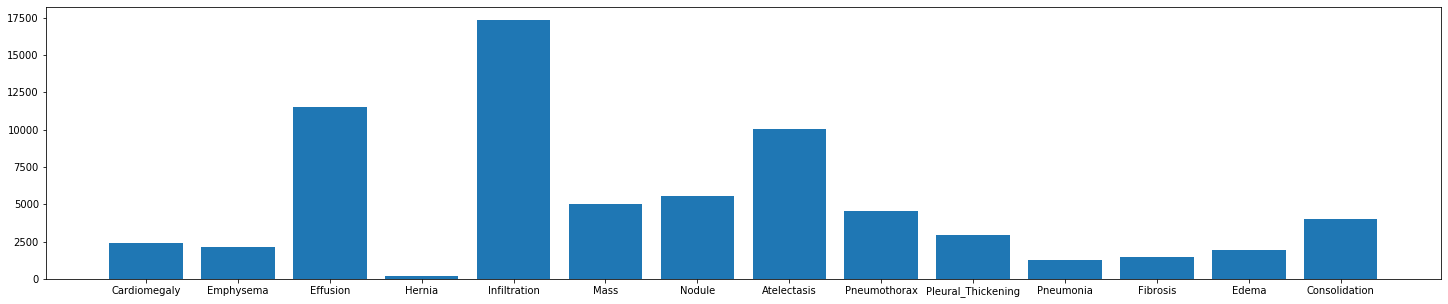

In [3]:
samples = {}
for col in train_df.columns:
    if col != 'Image Index':
        tot = train_df[col].sum()
        samples[col] = tot
        print(col, end=" ") 
        print(tot)

# Current split of data between the different classes
plt.figure(figsize=(25,5))
plt.bar(range(len(samples)), list(samples.values()), align='center')
plt.xticks(range(len(samples)), list(samples.keys()))
plt.show()